In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproduction
np.random.seed(322)

In [ ]:
class DataGenerator():
    def __init__(self, K=10, alfa=None, beta=None):
        self.K = K
        self.amplitude = alfa if alfa else np.random.uniform(20.0, 50.0)/100
        self.beta = beta if beta else np.random.uniform(1.0, 30.0)/100
        self.sampled_points = None
        self.x1 = self._sample()
        self.x2 = self._sample()
        self.x3 = self._sample()
        self.x4 = self._sample()
        self.x5 = self._sample()

    def _sample(self):
        return np.random.uniform(0.0, 100.0, self.K)/100

    def f(self, x1, x2, x3, x4, x5):
        y1 = x2*(1 + (x1+self.beta)*self.amplitude) #потребление
        y2 = x3*(1 + (x1+x2+x4+x5+self.beta)*self.amplitude) #производство
        y3 = abs(y2-y1+self.beta) #импорт
        y4 = abs(y2+y3-y1+self.beta) #экспорт
        return y1*1000, y2*1000, y3*10, y4*10

    def batch(self, x1 = None, x2 = None, x3 = None, x4 = None, x5 = None):
        if x1 is None:
            x1 = self.x1
        if x2 is None:
            x2 = self.x2
        if x3 is None:
            x3 = self.x3
        if x4 is None:
            x4 = self.x4
        if x5 is None:
            x5 = self.x5
        y1, y2, y3, y4 = self.f(x1, x2, x3, x4, x5)
        x = []
        y = []
        for i in range(0,len(x1)):
            temp_x = [x1[i], x2[i], x3[i], x4[i], x5[i]]
            x.append(temp_x)
        for i in  range(0,len(y1)):
            temp_y = [y1[i], y2[i], y3[i], y4[i]]
            y.append(temp_y)
        return x, y

    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(
            x1=np.linspace(1, 99, K)/100,
            x2=np.linspace(1, 99, K)/100,
            x3=np.linspace(1, 99, K)/100,
            x4=np.linspace(1, 99, K)/100,
            x5=np.linspace(1, 99, K)/100,
        )




batches = []
for i in range(2):
    batches.append(DataGenerator(K=3).equally_spaced_samples())
    (x,y) = batches[i]
    print(x)
    print(y)

In [3]:
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(256, input_shape=(5,))
        self.hidden2 = keras.layers.Dense(128)
        self.hidden3 = keras.layers.Dense(64)
        self.out = keras.layers.Dense(4)

    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = keras.activations.relu(self.hidden3(x))
        x = keras.activations.linear(self.out(x))
        return x

In [4]:
def copy_model(model, x):
    copied_model = MyModel()
    copied_model.forward(x)
    copied_model.set_weights(model.get_weights())
    return copied_model

In [5]:
from keras import backend as K
def root_mean_squared_error(model, x, y):
        return K.sqrt(K.mean(K.square(model.forward(x) - y)))

In [39]:
def generate_dataset(K, train_size=10000, test_size=600):
    def _generate_dataset(size):
        return [DataGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size)

train_ds, test_ds = generate_dataset(K=10)

In [59]:
def TaskBatches(X, BatchSize):

    m = len(X)
    miniBatches = []

    num_batches = m // BatchSize
    for k in range(0, num_batches):
        batch_x = []
        batch_y = []
        for i in range(0,BatchSize):
          (x,y) = X[i].batch()
          batch_x.append(x[0])
          batch_y.append(y[0])
        miniBatches.append([batch_x,batch_y])

    if m % BatchSize != 0:
        batch_x = []
        batch_y = []
        for i in range(0, m%BatchSize):
          (x,y) = X[i].batch()
          batch_x.append(x)
          batch_y.append(x)
        miniBatches.append((batch_x,batch_y))

    return miniBatches

In [ ]:
def generate_dataset(K, train_size=4):
    def _generate_dataset(size):
        return [DataGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size)

tasks = generate_dataset(K=1)

task_batches = TaskBatches(tasks,2)
print(task_batches)

In [61]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.MAE(y, pred_y))

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mae = loss_fn(logits, y)
    return mae, logits

def train_maml(model, train_ds, test_ds, epochs, lr_inner=0.1, show_step = 100):
    optimizer = keras.optimizers.Adam()
    total_test_loss_arr = []
    total_train_loss_arr = []
    for epo in range(epochs):
        test_loss_arr = []
        train_loss_arr = []
        start = time.time()
        steps_loss = []
        task_batches = TaskBatches(train_ds,2)
        for i, t in enumerate(random.sample(range(0, len(task_batches)), len(task_batches))):
            lr = lr_inner
            x = task_batches[t][0]
            y = task_batches[t][1]
            x = np.array(x)
            y = np.array(y)

            if len(model.get_weights()) == 0:
                model.forward(x)
            with tf.GradientTape() as test_tape:

                with tf.GradientTape() as train_tape:
                    loss, _ = compute_loss(model, x, y)
                    gradients = train_tape.gradient(loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel, tf.multiply(lr, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias, tf.multiply(lr, gradients[k+1]))
                    k += 2

                loss, _ = compute_loss(model_copy, x, y)

                gradients = test_tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                steps_loss.append(loss)
                if i%show_step == 0:
                  print('Step {}: loss_train = {}'.format(i,sum(steps_loss) / len(steps_loss)))

        for i, t in enumerate(random.sample(range(0, len(train_ds)), len(train_ds))):
            x, y = train_ds[t].batch()
            x = np.array(x)
            y = np.array(y)
            test_loss = root_mean_squared_error(model, x, y)
            train_loss_arr.append(test_loss)

        for i, t in enumerate(random.sample(range(0, len(test_ds)), len(test_ds))):
          x, y = train_ds[t].batch()
          x = np.array(x)
          y = np.array(y)
          loss = root_mean_squared_error(model, x, y)
          test_loss_arr.append(loss)


        print('Epo {}: loss_train = {}, loss_test = {}, Time to run {}'
        .format(epo, sum(train_loss_arr) / len(train_loss_arr), sum(test_loss_arr) / len(test_loss_arr), time.time() - start))
        total_test_loss_arr.append(sum(test_loss_arr) / len(test_loss_arr))
        total_train_loss_arr.append(sum(train_loss_arr) / len(train_loss_arr))
    plt.plot(total_train_loss_arr)
    plt.plot(total_test_loss_arr)
    plt.show()

Step 0: loss_train = 535.4549560546875
Step 100: loss_train = 462.6475830078125
Step 200: loss_train = 435.9463195800781
Step 300: loss_train = 407.0378723144531
Step 400: loss_train = 380.9707336425781
Step 500: loss_train = 364.1639404296875
Step 600: loss_train = 351.3271484375
Step 700: loss_train = 338.0254211425781
Step 800: loss_train = 316.5018005371094
Step 900: loss_train = 291.8456115722656
Step 1000: loss_train = 264.1422119140625
Step 1100: loss_train = 240.57302856445312
Step 1200: loss_train = 220.94635009765625
Step 1300: loss_train = 204.20314025878906
Step 1400: loss_train = 189.89678955078125
Step 1500: loss_train = 177.4832000732422
Step 1600: loss_train = 166.573974609375
Step 1700: loss_train = 156.98207092285156
Step 1800: loss_train = 148.40914916992188
Step 1900: loss_train = 140.76559448242188
Step 2000: loss_train = 133.90919494628906
Step 2100: loss_train = 127.6893310546875
Step 2200: loss_train = 121.99879455566406
Step 2300: loss_train = 116.7850265502929

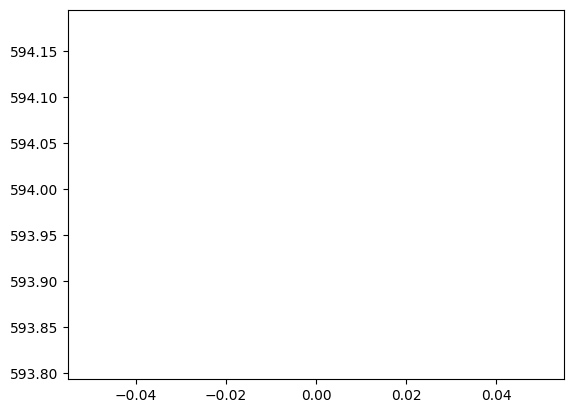

In [62]:
maml = MyModel()
train_maml(maml, train_ds, test_ds, 1)

In [ ]:
train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
train_data = train_df.drop(columns = ['Country'])

train_data_arr = []
train_targets_arr = []

test_data_arr = []
test_target_arr = []
r = random.randint(0,10)
k= 0
valueRange = 0

for i in range(1,len(train_data)):

  for j in range(i-1,i - valueRange - 1,-1):
    if(j<=0):
      continue
    data_row = train_data[i-1:i]
    data_row.at[i-1, 'Year'] = 1990 + j
    if k == 11:
      r = random.randint(0,10)
      k=0
    if k == r:
      test_data_arr.append(data_row.copy())
      target_row = train_data[j-1:j]
      test_target_arr.append(target_row.drop(columns = ['Year']))
      k+=1
      continue
    k+=1
    train_data_arr.append(data_row.copy())
    target_row = train_data[j-1:j]
    train_targets_arr.append(target_row.drop(columns = ['Year']))

  for j in range(i,len(train_data)):
    data_row = train_data[i-1:i]
    data_row.at[i-1, 'Year'] = 1990 + j
    if k == 11:
      r = random.randint(0,10)
      k=0
    if k == r:
      test_data_arr.append(data_row.copy())
      target_row = train_data[j:j+1]
      test_target_arr.append(target_row.drop(columns = ['Year']))
      k+=1
      continue
    k+=1
    train_data_arr.append(data_row.copy())
    target_row = train_data[j:j+1]
    train_targets_arr.append(target_row.drop(columns = ['Year']))
    if j-i > valueRange-1:
      break

train_targets = pd.concat(train_targets_arr)
train_data = pd.concat(train_data_arr)

test_targets = pd.concat(test_target_arr)
test_data = pd.concat(test_data_arr)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_features = scaler.transform(train_data)
train_data = pd.DataFrame(data = scaled_features)

scaled_features = scaler.transform(test_data)
test_data = pd.DataFrame(data = scaled_features)

NameError: ignored

In [ ]:
train_data_np = train_data.to_numpy()
train_targets_np = train_targets.to_numpy()

test_data_np = test_data.to_numpy()
test_targets_np = test_targets.to_numpy()

In [ ]:
def MiniBatches(X, Y, MiniBatchSize):

    m = X.shape[0]
    miniBatches = []

    num_minibatches = m // MiniBatchSize
    for k in range(0, num_minibatches):
        miniBatch_X = X[k * MiniBatchSize:(k + 1) * MiniBatchSize,:]
        miniBatch_Y = Y[k * MiniBatchSize:(k + 1) * MiniBatchSize,:]
        miniBatch = (miniBatch_X, miniBatch_Y)
        miniBatches.append(miniBatch)

    if m % MiniBatchSize != 0:
        miniBatch_X = X[num_minibatches * MiniBatchSize:, :]
        miniBatch_Y = Y[num_minibatches * MiniBatchSize:, :]

        miniBatch = (miniBatch_X, miniBatch_Y)
        miniBatches.append(miniBatch)

    return miniBatches

In [ ]:
test_loss_arr = []
train_loss_arr = []

def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.MAE(y, pred_y))

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mae = loss_fn(logits, y)
    return mae, logits

def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def train_batch(x, y, model, optimizer):
    gradients, loss = compute_gradients(model, x, y)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def eval_test(model, optimizer, x_train, y_train, x_test, y_test, num_steps=(0, 1, 10)):
    fit_res = []

    if 0 in num_steps:
        loss, logits = compute_loss(model, x_train, y_train)
        print(loss)

    for step in range(1, np.max(num_steps) + 1):
        batch = MiniBatches(x_train, y_train, 1)
        for i, t in enumerate(random.sample(range(0, len(batch)), len(batch))):
            x_batch,y_batch = batch[t]
            train_batch(x_batch, y_batch, model, optimizer)
        loss_test = root_mean_squared_error(model, x_test, y_test)
        loss_train = root_mean_squared_error(model, x_train, y_train)
        print('Epoh {}:loss_test = {} loss_train = {}'.format(step, loss_test, loss_train))
        test_loss_arr.append(loss_test)
        train_loss_arr.append(loss_train)
    return model


def eval_for_test(model, train_data_np, train_targets_np, test_data, test_targets,  num_steps=(0, 1, 10), lr=0.001):

    copied_model = copy_model(model, train_data_np)

    optimizer = keras.optimizers.SGD(learning_rate=lr)

    model = eval_test(copied_model, optimizer, train_data_np, train_targets_np, test_data, test_targets, num_steps)
    plt.plot(test_loss_arr)
    plt.plot(train_loss_arr)
    plt.show()
    return model

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
def error(model):
  pred = model.forward(train_data_np)
  print(mean_absolute_percentage_error(pred,train_targets_np))
  print(pred)
  print(train_targets_np)
  print(pred/train_targets_np)

In [ ]:
model = eval_for_test(maml, train_data_np, train_targets_np, test_data_np, test_targets_np)

In [ ]:
error(model)

Проверка на данных за последние несколько лет

In [ ]:
train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
train_data = train_df.drop(columns = ['Country']).tail(5)

last_year_data_arr = []
last_year_targets_arr = []

valueRange = 0

for i in range(1,len(train_data)):

  for j in range(i,len(train_data)):
    data_row = train_data.head(i).tail(1)
    data_row.at[i+25, 'Year'] = (int)(2015 + j)
    last_year_data_arr.append(data_row.copy())
    target_row = train_data[j:j+1]
    last_year_targets_arr.append(target_row.drop(columns = ['Year']))
    if j-i > valueRange-1:
      break

last_year_targets = pd.concat(last_year_targets_arr)
last_year_data = pd.concat(last_year_data_arr)

scaler2 = MinMaxScaler()
scaler2.fit(last_year_data)
scaled_features2 = scaler2.transform(last_year_data)
last_year_data = pd.DataFrame(data = scaled_features2)

last_year_data_np = last_year_data.to_numpy()
last_year_targets_np = last_year_targets.to_numpy()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
pred = model.forward(last_year_data_np)
print(mean_absolute_percentage_error(pred, last_year_targets_np))
print(pred)
print(last_year_targets_np)
print(pred/last_year_targets_np)

In [ ]:
data = {'Year': [2019], 'Eggs Food': [2238.0],
        'Eggs Production': [2388.0], 'Eggs Import Quantity': [99.0],
       'Eggs Export Quantity': [15.0] }

result = {'Year': [1999], 'Eggs Food': [1981.0],
        'Eggs Production': [2033.0], 'Eggs Import Quantity': [9.0],
       'Eggs Export Quantity': [7.0]}

input_data = pd.DataFrame(data)
scaled_features = scaler.transform(input_data)
input_data = pd.DataFrame(data = scaled_features)
input_data_np = input_data.to_numpy()

input_data = pd.DataFrame(result)
result_data = pd.DataFrame(data = input_data)
result_data_np = result_data.to_numpy()

pred = model.forward(input_data_np)
print(input_data_np)
#print(pred/result_data_np)

[[2019. 2238. 2388.   99.   15.]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
